In [ ]:
#for image cropping
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.ndimage as ndi
from skimage.exposure import rescale_intensity

#For TDA Feature Selection
import subprocess
!pip install persim
import persim
!pip install gudhi
import gudhi as gd  # Alternative for DIPHA if needed

#For Model Definition, Training
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim

!pip install pytorch_lightning
import pytorch_lightning as pl
from sklearn.linear_model import LogisticRegression
#!pip install torch torchvision torchaudio
!pip install torch-geometric
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.layers import Conv3D, BatchNormalization, ReLU, Dropout, GlobalAveragePooling3D, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.optimizers import Adam

from torch.utils.data import TensorDataset, DataLoader

!pip install -q torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

from torch_geometric.explain.algorithm import GNNExplainer
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 93.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.0/936.0 kB 2.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **0. Cohort Selection**

Here is a Python implementation of the ADNI data processing pipeline as described, incorporating:

- **Cohort Selection**: Selecting AD and CN subjects with matched ages.
- **Preprocessing**: Standard pipeline using clinica and fmriprep for MNI registration, intensity normalization, and brain extraction.
- **Feature Extraction**:
  a) Patch Extraction: Cropping to an inner brain region and subdividing into 64 non-overlapping patches.
  b) Hippocampus Segmentation: Using the Cerebrum Atlas with a three-voxel dilation.
  c) Topological Data Analysis (TDA):
    c1) Computing persistent homology using DIPHA.
    c2) Transforming persistence diagrams into persistence images using persim.

In [ ]:
def select_cohort(adni_csv_path):
    # Load the ADNI dataset containing subject information
    adni_df = pd.read_csv(adni_csv_path)

    # Filter for AD and CN subjects
    selected_df = adni_df[adni_df['Group'].isin(['AD', 'CN'])]

    # For matched ages, we could apply a simple age range filtering (e.g., mean age ± 7 years)
    mean_age = 77  #Selects AD and CN subjects from ADNI with matched age (mean 77 ± 7)
    age_range = (mean_age - 7, mean_age + 7)
    selected_df = selected_df[selected_df['Age'].between(age_range[0], age_range[1])]

    # Keep only 358 subjects
    selected_df = selected_df.sample(n=38, random_state=42)  # Randomly select subset if needed

    # Map labels: 'CN' -> 0, 'AD' -> 1
    selected_df['label'] = selected_df['Group'].map({'CN': 0, 'AD': 1})
    selected_df['subjectID'] = selected_df['Subject']

    return selected_df[['subjectID', 'label']]

# **1. Input Image Processing**

In [ ]:
def normalize_intensity(image):
    #Normalize intensity to [0,1] range.
    img = image.astype(np.float32)
    img -= img.min()
    img /= img.max()
    return img

def crop_brain_region(image, crop_size=(120, 144, 120)):
    """Crop the image to the inner brain region in MNI space."""
    if (len(image.shape) == 4):
      x, y, z, zz = image.shape
    else:
      x, y, z = image.shape

    cx, cy, cz = crop_size
    start_x, start_y, start_z = (x - cx) // 2, (y - cy) // 2, (z - cz) // 2
    return image[start_x:start_x+cx, start_y:start_y+cy, start_z:start_z+cz]

def preprocess_fmriprep_mni(filepath):
    """Preprocess an MNI-aligned fMRIPrep NIfTI image: normalization & cropping."""
    img = nib.load(filepath).get_fdata()
    img = normalize_intensity(img)
    img = crop_brain_region(img)
    return img

def extract_patches(image, patch_size=(30, 36, 30)):
    """Extract non-overlapping 3D patches from the cropped MNI-aligned image."""
    if (len(image.shape) == 4):
      cx, cy, cz, czz = image.shape
    else:
      cx, cy, cz = image.shape
    px, py, pz = patch_size
    patches = []

    for i in range(0, cx, px):
        for j in range(0, cy, py):
            for k in range(0, cz, pz):
                patch = image[i:i+px, j:j+py, k:k+pz]
                if patch.shape == patch_size:  # Ensure exact patch size
                    patches.append(patch)

    return np.array(patches)

**Apply Cerebrum Atlas (Manera et al., 2020) to segment the left and right hippocampus**

In [ ]:
from scipy.ndimage import zoom

def load_atlas_mask(atlas_path, dilation=3):
    """Load the hippocampus mask from the Cerebrum Atlas and apply 3-voxel dilation."""
    print ("ATLAS PATH"+atlas_path)
    atlas_mask = nib.load(atlas_path).get_fdata()
    atlas_mask = (atlas_mask > 0).astype(np.uint8)  # Binarize mask
    atlas_mask_dilated = ndi.binary_dilation(atlas_mask, iterations=dilation)
    return atlas_mask_dilated.astype(np.uint8)

def resample_mask(atlas_path, target_shape):
    # Load the atlas mask
    atlas = nib.load(atlas_path)
    atlas_data = atlas.get_fdata()

    # Calculate the zoom factor for each dimension
    zoom_factors = [t / s for t, s in zip(target_shape, atlas_data.shape)]

    # Resample the atlas data
    resampled_atlas = zoom(atlas_data, zoom_factors, order=1)  # Use linear interpolation

    return resampled_atlas

def apply_hippocampus_mask(image, atlas_mask):
    """Apply hippocampus segmentation mask to the brain image."""
    return image * atlas_mask  # Zero out everything outside the hippocampus

**TDA Feature Selection**

In [ ]:
import gudhi

def compute_persistent_homology_with_GUDHI(image, tau_values=np.linspace(0, 1, 50)):
    """Compute persistent homology using GUDHI."""

    # Flatten the 3D image to a 1D array for GUDHI input
    flattened_image = image.flatten()

    # Create a cubical complex from the image
    cubical_complex = gudhi.CubicalComplex(dimensions=image.shape, top_dimensional_cells=flattened_image)

    # Compute persistence
    cubical_complex.persistence()

    # Extract persistence diagrams for dimensions 0, 1, and 2
    diagrams = {dim: cubical_complex.persistence_intervals_in_dimension(dim) for dim in [0, 1, 2]}

    # Filter out infinite values from diagrams
    cleaned_diagrams = {dim: diag[np.isfinite(diag).all(axis=1)] for dim, diag in diagrams.items()}

    # Generate persistence images for dimensions d=0, 1, 2 using Persim
    persistence_images = {}
    for dim, diag in cleaned_diagrams.items():
        if len(diag) > 0:
            # Configure the PersistenceImager with updated arguments
            persistence_imager = persim.PersistenceImager(pixel_size=0.01, birth_range=(0, 1), pers_range=(0, 1))
            persistence_imager.fit(diag)
            persistence_images[dim] = persistence_imager.transform(diag)
        else:
            persistence_images[dim] = None

    return persistence_images

**Image Processing Pipeline**

In [ ]:
#Function that processes each subject's image
def process_subject(data_dir, atlas_path, subject_id, label):
  """Process data for each subject."""
  # Assuming images are in the format 'sub-<subject_id>_T1w.nii.gz'
  image_path = f"{data_dir}/{subject_id}.nii.gz"

  # Preprocess image (intensity normalization, cropping) CONFIRMED CORRECT
  img = preprocess_fmriprep_mni(image_path)  #Output shape (120,144,120)

  # Extract patches from image  64 non-overlapping patches of 30x36x30 px. CONFIRMED CORRECT
  patches = extract_patches(img) # Output shape (64, 30, 360, 30)

  # Apply hippocampus mask
  target_shape = (120, 144, 120)  # Shape of your preprocessed ADNI image
  atlas_mask = resample_mask(atlas_path, target_shape)

  hippocampus_segmented = apply_hippocampus_mask(img, atlas_mask)

  # Compute persistent homology for TDA
  persistence_images = compute_persistent_homology_with_GUDHI(img)

  return patches, hippocampus_segmented, persistence_images, label

In [ ]:
def process_cohort(adni_csv_path, data_dir, atlas_path):
  """Process the entire ADNI cohort for classification."""

  # Select subjects for cohort
  cohort = select_cohort(adni_csv_path) #ADNI_CSV_PATH is the CSV study download from IDA

  all_patches = []
  all_hippocampus_segmented = []
  all_persistence_images = []
  all_labels = []

  print (cohort.shape)

  i = 1

  for subject_id, label in cohort[['subjectID', 'label']].values:
    print ("Processing Subject: " + subject_id + " (" + str(i) + ")")
    i += 1
    patches, hippocampus_segmented, persistence_images, label = process_subject(data_dir, atlas_path, subject_id, label)

    all_patches.append(patches)
    all_hippocampus_segmented.append(hippocampus_segmented)
    all_persistence_images.append(persistence_images)
    all_labels.append(label)

    #for testing REMOVE WHEN DONE
    #if i == 10:
    #  break

  return np.array(all_patches), np.array(all_hippocampus_segmented), np.array(all_persistence_images), np.array(all_labels)

# **2. Model Definition**

In [ ]:
# ----- 1. 3D CNN for Image-based Features -----
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv3D, BatchNormalization, ReLU, Dropout,
    GlobalAveragePooling3D, Dense
)
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import HeUniform

def build_3d_cnn(input_shape):
    inputs = Input(shape=input_shape)

    x = Conv3D(32, (3, 3, 3), padding="same", kernel_initializer=HeUniform())(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.3)(x)

    x = Conv3D(64, (3, 3, 3), padding="same", kernel_initializer=HeUniform())(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.3)(x)

    x = Conv3D(128, (3, 3, 3), padding="same", kernel_initializer=HeUniform())(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.3)(x)

    x = GlobalAveragePooling3D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.4)(x)

    outputs = Dense(1, activation="sigmoid")(x)  # Binary classification

    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="binary_crossentropy",
                  metrics=["AUC"])
    return model

In [ ]:
# ----- 3. Patch Combination using Logistic Regression -----
def train_logistic_regression(cnn_outputs, labels):
    """Train logistic regression on CNN patch outputs"""
    clf = LogisticRegression(class_weight="balanced", solver="liblinear")
    clf.fit(cnn_outputs, labels)
    return clf

In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_max_pool

# ----- 4. Graph Neural Network for Patch Aggregation -----
class GNNPatchAggregator(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim=64, output_dim=1):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.classifier = torch.nn.Linear(output_dim, 1)

    def forward(self, x, edge_index, batch=None):
        # If x is passed as a flat vector, unsqueeze
        if len(x.shape) == 1:
            x = x.unsqueeze(-1)

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        if batch is not None:
            x = global_max_pool(x, batch)

        x = torch.sigmoid(self.classifier(x)).squeeze()
        return x
        #return self.classifier(x).squeeze()

    def forward_from_batch(self, data):
        # Original version for training/validation
        return self(data.x, data.edge_index, data.batch)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

    def training_step(self, batch, batch_idx):
        out = self.forward_from_batch(batch).squeeze()
        y = batch.y.view(-1)
        loss = F.binary_cross_entropy_with_logits(out, y)
        return loss

# **3. Model Training**

In [ ]:
def load_data_for_training (adni_csv_path, data_dir, atlas_path):
  patches, hippocampus_segmented, persistence_images, labels = process_cohort(adni_csv_path, data_dir, atlas_path)

  return patches, hippocampus_segmented, persistence_images, labels

## **3.1. Grad-CAM Visualization function**

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def get_last_conv3d_layer(model):
    """Returns the name of the last Conv3D layer in the model."""
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv3D):
            return layer.name
    raise ValueError("No Conv3D layer found in the model.")

def compute_gradcam(model, input_volume, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(input_volume)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2, 3))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.nn.relu(heatmap)
    heatmap = heatmap / tf.reduce_max(heatmap + tf.keras.backend.epsilon())
    return heatmap.numpy()

def plot_combined_gradcam_grid(patches, heatmaps, slice_axis=1, patches_per_row=8):
    """
    Combine multiple patch slices and heatmaps into single grid images.

    Args:
        patches (np.ndarray): Shape (N, D, H, W)
        heatmaps (np.ndarray): Shape (N, H, W)
        slice_axis (int): Axis to take 2D slice from
        patches_per_row (int): Number of images per row in the final grid
    """
    N = patches.shape[0]
    rows = (N + patches_per_row - 1) // patches_per_row

    patch_slices = []
    heatmap_overlays = []

    for i in range(N):
        patch = patches[i]
        heatmap = heatmaps[i]

        # Take middle slice
        slice_idx = patch.shape[slice_axis] // 2
        if slice_axis == 0:
            patch_slice = patch[slice_idx, :, :]
        elif slice_axis == 1:
            patch_slice = patch[:, slice_idx, :]
        else:
            patch_slice = patch[:, :, slice_idx]

        # Normalize
        patch_slice = patch_slice / (np.max(patch_slice) + 1e-6)
        heatmap = heatmap / (np.max(heatmap) + 1e-6)

        # Resize if needed to match (e.g., patch and heatmap dims mismatch)
        if heatmap.shape != patch_slice.shape:
            heatmap = tf.image.resize(heatmap[..., np.newaxis], patch_slice.shape[::-1])
            heatmap = tf.squeeze(heatmap).numpy()

        # Save slices
        patch_slices.append(patch_slice)
        heatmap_overlays.append((patch_slice, heatmap))

    # Create image grids
    def build_grid(image_list, is_overlay=False):
        img_h, img_w = image_list[0][0].shape if is_overlay else image_list[0].shape
        grid = np.zeros((rows * img_h, patches_per_row * img_w, 3))  # RGB

        for idx, img_data in enumerate(image_list):
            r = idx // patches_per_row
            c = idx % patches_per_row
            y, x = r * img_h, c * img_w

            if is_overlay:
                patch_img, heat = img_data
                base = np.stack([patch_img]*3, axis=-1)
                cmap = plt.cm.get_cmap("jet")(heat)[:, :, :3]
                overlay = 0.5 * base + 0.5 * cmap
            else:
                base = np.stack([img_data]*3, axis=-1)
                overlay = base

            grid[y:y+img_h, x:x+img_w, :] = overlay

        return grid

    patch_grid = build_grid(patch_slices)
    heatmap_grid = build_grid(heatmap_overlays, is_overlay=True)

    # Plot the two big images
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    axs[0].imshow(patch_grid)
    axs[0].set_title("All Patch Slices")
    axs[0].axis('off')

    axs[1].imshow(heatmap_grid)
    axs[1].set_title("All Grad-CAM Overlays")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

def visualize_gradcam_for_patch(cnn_model, patch, subject_index=0, patch_index=0, slice_axis=1):
    """
    Visualizes Grad-CAM for a specific patch of a subject.

    Args:
        cnn_model: Trained 3D CNN model.
        patches: List of lists of 3D patches [subjects][patches].
        subject_index: Index of the subject to visualize.
        patch_index: Index of the patch within the subject.
        slice_axis: Axis to slice on (0, 1, or 2).
    """
    # Ensure patch is expanded to match batch shape
    patch = np.expand_dims(patch, axis=0).astype("float32")

    last_conv = get_last_conv3d_layer(cnn_model)
    heatmap = compute_gradcam(cnn_model, patch, last_conv)

    plot_combined_gradcam_grid(patch[0], heatmap, slice_axis=1)

## **3.2. Training function**

In [ ]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from tensorflow.keras.preprocessing.sequence import pad_sequences
import networkx as nx
from torch_geometric.utils import to_networkx

# ---- Custom Dataset ----
class GNNDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.data = features
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        num_nodes = x.shape[0]
        edge_index = torch.combinations(torch.arange(num_nodes), r=2).t().contiguous()
        self_loops = torch.arange(num_nodes).unsqueeze(0).repeat(2, 1)
        edge_index = torch.cat([edge_index, self_loops], dim=1)
        return Data(x=x, edge_index=edge_index, y=self.labels[idx].float().view(1))


def build_combined(cnn_embeds, persistence_images):
    MAX_TDA_LEN = 5000

    combined = []
    for cnn_vec, tda_dict in zip(cnn_embeds, persistence_images):
        tda_parts = [np.array(v).flatten() for v in tda_dict.values()]
        tda_flat = np.concatenate(tda_parts)

        # Truncate or pad TDA features
        if len(tda_flat) > MAX_TDA_LEN:
            tda_flat = tda_flat[:MAX_TDA_LEN]
        else:
            tda_flat = np.pad(tda_flat, (0, MAX_TDA_LEN - len(tda_flat)))

        cnn_vec = np.array(cnn_vec).flatten()
        combined_vec = np.concatenate([cnn_vec, tda_flat])
        combined.append(combined_vec)
    return np.stack(combined).astype(np.float32)

# ---- Train LR ----
def train_logistic_regression(X_train, y_train):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    return model

# ---- Metrics Logging ----
'''
def evaluate_predictions(y_true, y_pred_probs):
    y_pred = np.round(y_pred_probs)
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "auc": roc_auc_score(y_true, y_pred_probs),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
    }
'''
def evaluate_predictions(y_true, y_pred):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
    metrics = {
        'accuracy': accuracy_score(y_true, (y_pred > 0.5)),
        'precision': precision_score(y_true, (y_pred > 0.5)),
        'recall': recall_score(y_true, (y_pred > 0.5)),
        'auc': roc_auc_score(y_true, y_pred)
    }
    return metrics

# ---- Main Training Function ----
def train_evaluate_models(patches, persistence_images, labels):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    metrics = {
        "cnn_lr": {"accuracy": [], "auc": [], "precision": [], "recall": []},
        "cnn_gnn": {"accuracy": [], "auc": [], "precision": [], "recall": []},
        "cnn_pers_gnn": {"accuracy": [], "auc": [], "precision": [], "recall": []},
    }

    for train_idx, test_idx in skf.split(patches, labels):
        X_train, X_test = patches[train_idx], patches[test_idx]
        y_train, y_test = labels[train_idx], labels[test_idx]

        print ("Model #1: CNN + Logistic Regression")
        cnn_model = build_3d_cnn(input_shape=patches.shape[1:])
        cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        cnn_model.fit(
            X_train, y_train,
            validation_split=0.25,
            epochs=20,
            batch_size=8,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)]
        )

        cnn_train_embeddings = cnn_model.predict(X_train)
        cnn_test_embeddings = cnn_model.predict(X_test)

        # ---- (1) CNN + Logistic Regression ----
        lr_model = train_logistic_regression(cnn_train_embeddings, y_train)
        lr_preds = lr_model.predict_proba(cnn_test_embeddings)[:, 1]

        for k, v in evaluate_predictions(y_test, lr_preds).items():
            metrics["cnn_lr"][k].append(v)
        print("CNN RESULTS:")
        print (metrics["cnn_lr"])

        # ---- (2) CNN → GNN ----
        print ("Model #2: CNN → GNN")

        gnn_train_data = torch.tensor(cnn_train_embeddings).float().unsqueeze(1)  # [num_samples, 1, dim]
        gnn_test_data = torch.tensor(cnn_test_embeddings).float().unsqueeze(1)
        gnn_train_labels = torch.tensor(y_train).float()
        gnn_test_labels = torch.tensor(y_test).float()

        gnn_model = GNNPatchAggregator(input_dim=cnn_train_embeddings.shape[1])
        train_loader = DataLoader(GNNDataset(gnn_train_data, gnn_train_labels), batch_size=8)
        test_loader = DataLoader(GNNDataset(gnn_test_data, gnn_test_labels), batch_size=8)

        trainer = pl.Trainer(max_epochs=30, enable_progress_bar=False)
        trainer.fit(gnn_model, train_loader)

        gnn_preds = []
        for batch in test_loader:
            with torch.no_grad():
                pred = torch.sigmoid(gnn_model.forward_from_batch(batch)).squeeze().cpu().numpy()
                #pred = torch.sigmoid(gnn_model(batch)).squeeze().cpu().numpy()
                gnn_preds.extend(pred if pred.ndim > 0 else [pred])
        for k, v in evaluate_predictions(y_test, np.array(gnn_preds)).items():
            metrics["cnn_gnn"][k].append(v)

        print("CNN+GNN RESULTS:")
        print (metrics["cnn_gnn"])
        print ("-------------------")

        # ---- (3) CNN + Persistence → GNN ----
        print ("Model #3: CNN + Persistence → GNN")

        concat_train_np = build_combined(cnn_train_embeddings, persistence_images[train_idx])
        concat_test_np = build_combined(cnn_test_embeddings, persistence_images[test_idx])

        # Convert to tensors for the dataset
        concat_train = torch.tensor(concat_train_np).float().unsqueeze(1)
        concat_test = torch.tensor(concat_test_np).float().unsqueeze(1)

        gnn_model_pers = GNNPatchAggregator(input_dim=concat_train.shape[-1])
        train_loader_pers = DataLoader(GNNDataset(concat_train, gnn_train_labels), batch_size=8)
        test_loader_pers = DataLoader(GNNDataset(concat_test, gnn_test_labels), batch_size=8)

        trainer = pl.Trainer(max_epochs=30, enable_progress_bar=False)
        trainer.fit(gnn_model_pers, train_loader_pers)

        gnn_preds_pers = []
        for batch in test_loader_pers:
            with torch.no_grad():
                pred = torch.sigmoid(gnn_model_pers(batch.x, batch.edge_index, batch.batch)).squeeze().cpu().numpy()
                #pred = torch.sigmoid(gnn_model_pers(batch)).squeeze().cpu().numpy()
                gnn_preds_pers.extend(pred if pred.ndim > 0 else [pred])
        for k, v in evaluate_predictions(y_test, np.array(gnn_preds_pers)).items():
            metrics["cnn_pers_gnn"][k].append(v)

        print (metrics["cnn_pers_gnn"])
        print("CNN+Pred+GNN RESULTS:")
        print (metrics["cnn_pers_gnn"])
        print ("-------------------")

        #Visualize
        #plt.imshow(persistence_images[test_idx[i]].reshape((8, 8)), cmap='hot')  # Adjust reshape if needed
        #plt.title(f"Persistence Image for Test Sample {i}")
        #plt.colorbar()
        #plt.show()

    #Visualization
    sample_idx = 0  # you can loop or randomize this later
    visualize_gradcam_for_patch(
            cnn_model=cnn_model,
            patch=X_test[sample_idx],
            subject_index=sample_idx,
            patch_index=0,
            slice_axis=1
      )


    return metrics


# **4. Run the code**

In [ ]:
# ----- 7. Run Full Experiment -----
adni_csv_path = "/content/drive/My Drive/ADNI_filtered_output.csv"                              #"/path/to/ADNIMERGE.csv"  # Path to ADNI dataset CSV
data_dir = "/content/drive/My Drive/ADNI"                                                       #"/path/to/adni/data" # Directory containing preprocessed MRI scans
atlas_path = "/content/drive/My Drive/Atlas_Mask_mni_icbm152_t1_tal_nlin_asym_09b_hires.nii.gz" #"/path/to/hippocampus/atlas.nii.gz"  # Path to hippocampus atlas mask

patches, hippocampus_segmented, persistence_images, labels = load_data_for_training (adni_csv_path, data_dir, atlas_path)

(38, 2)
Processing Subject: 126_S_0784 (1)
Processing Subject: 019_S_5012 (2)
Processing Subject: 051_S_1123 (3)
Processing Subject: 057_S_0818 (4)
Processing Subject: 023_S_0084 (5)
Processing Subject: 041_S_1368 (6)
Processing Subject: 014_S_0548 (7)
Processing Subject: 131_S_0497 (8)
Processing Subject: 022_S_0007 (9)
Processing Subject: 006_S_4357 (10)
Processing Subject: 022_S_0066 (11)
Processing Subject: 067_S_0177 (12)
Processing Subject: 020_S_0883 (13)
Processing Subject: 126_S_0605 (14)
Processing Subject: 073_S_4382 (15)
Processing Subject: 131_S_0123 (16)
Processing Subject: 014_S_0328 (17)
Processing Subject: 130_S_0969 (18)
Processing Subject: 128_S_0167 (19)
Processing Subject: 027_S_0403 (20)
Processing Subject: 002_S_1280 (21)
Processing Subject: 116_S_0382 (22)
Processing Subject: 062_S_0535 (23)
Processing Subject: 006_S_0547 (24)
Processing Subject: 029_S_0824 (25)
Processing Subject: 116_S_0487 (26)
Processing Subject: 024_S_1307 (27)
Processing Subject: 023_S_119

Model #1: CNN + Logistic Regression
1/1 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type    | Params | Mode 
-----------------------------------------------
0 | conv1      | GCNConv | 128    | train
1 | conv2      | GCNConv | 65     | train
2 | classifier | Linear  | 2      | train
-----------

CNN RESULTS:
{'accuracy': [0.5], 'auc': [np.float64(0.25)], 'precision': [0.0], 'recall': [0.0]}
Model #2: CNN → GNN


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type    | Params | Mode 
-----------------------------------------------
0 | conv1      | GCNConv | 320 K  | train
1 | conv2      | GCNConv | 65     | train

CNN+GNN RESULTS:
{'accuracy': [0.5], 'auc': [np.float64(0.5)], 'precision': [0.5], 'recall': [1.0]}
-------------------
Model #3: CNN + Persistence → GNN


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


{'accuracy': [0.5], 'auc': [np.float64(0.5)], 'precision': [0.5], 'recall': [1.0]}
CNN+Pred+GNN RESULTS:
{'accuracy': [0.5], 'auc': [np.float64(0.5)], 'precision': [0.5], 'recall': [1.0]}
-------------------
Model #1: CNN + Logistic Regression
1/1 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type    | Params | Mode 
-----------------------------------------------
0 | conv1      | GCNConv | 128    | train
1 | conv2      | GCNConv | 65     | train
2 | classifier | Linear  | 2      | train
-----------

CNN RESULTS:
{'accuracy': [0.5, 0.5], 'auc': [np.float64(0.25), np.float64(0.6875)], 'precision': [0.0, 0.0], 'recall': [0.0, 0.0]}
Model #2: CNN → GNN


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type    | Params | Mode 
-----------------------------------------------
0 | conv1      | GCNConv | 320 K  | train
1 | conv2      | GCNConv | 65     | train
2 | classifier | Linear  | 2      | train
-----------------------------------------------
320 K     Trainable params
0         Non-trainable params
320 K     Total params
1.281     Total estimated model params size (MB)
7         Modules in train mode
0         Modules i

CNN+GNN RESULTS:
{'accuracy': [0.5, 0.5], 'auc': [np.float64(0.5), np.float64(0.5)], 'precision': [0.5, 0.5], 'recall': [1.0, 1.0]}
-------------------
Model #3: CNN + Persistence → GNN


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


{'accuracy': [0.5, 0.5], 'auc': [np.float64(0.5), np.float64(0.5)], 'precision': [0.5, 0.5], 'recall': [1.0, 1.0]}
CNN+Pred+GNN RESULTS:
{'accuracy': [0.5, 0.5], 'auc': [np.float64(0.5), np.float64(0.5)], 'precision': [0.5, 0.5], 'recall': [1.0, 1.0]}
-------------------
Model #1: CNN + Logistic Regression
1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type    | Params | Mode 
-----------------------------------------------
0 | conv1      | GCNConv | 128    | train
1 | conv2      | GCNConv | 65     | train
2 | classifier | Linear  | 2      | train
-----------

CNN RESULTS:
{'accuracy': [0.5, 0.5, 0.5], 'auc': [np.float64(0.25), np.float64(0.6875), np.float64(0.1875)], 'precision': [0.0, 0.0, 0.0], 'recall': [0.0, 0.0, 0.0]}
Model #2: CNN → GNN


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type    | Params | Mode 
-----------------------------------------------
0 | conv1      | GCNConv | 320 K  | train
1 | conv2      | GCNConv | 65     | train

CNN+GNN RESULTS:
{'accuracy': [0.5, 0.5, 0.5], 'auc': [np.float64(0.5), np.float64(0.5), np.float64(0.5)], 'precision': [0.5, 0.5, 0.5], 'recall': [1.0, 1.0, 1.0]}
-------------------
Model #3: CNN + Persistence → GNN


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


{'accuracy': [0.5, 0.5, 0.5], 'auc': [np.float64(0.5), np.float64(0.5), np.float64(0.375)], 'precision': [0.5, 0.5, 0.5], 'recall': [1.0, 1.0, 1.0]}
CNN+Pred+GNN RESULTS:
{'accuracy': [0.5, 0.5, 0.5], 'auc': [np.float64(0.5), np.float64(0.5), np.float64(0.375)], 'precision': [0.5, 0.5, 0.5], 'recall': [1.0, 1.0, 1.0]}
-------------------
Model #1: CNN + Logistic Regression
1/1 ━━━━━━━━━━━━━━━━━━━━ 31s 31s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type    | Params | Mode 
-----------------------------------------------
0 | conv1      | GCNConv | 128    | train
1 | conv2      | GCNConv | 65     | train
2 | classifier | Linear  | 2      | train
-----------

CNN RESULTS:
{'accuracy': [0.5, 0.5, 0.5, 0.5714285714285714], 'auc': [np.float64(0.25), np.float64(0.6875), np.float64(0.1875), np.float64(0.25)], 'precision': [0.0, 0.0, 0.0, 0.0], 'recall': [0.0, 0.0, 0.0, 0.0]}
Model #2: CNN → GNN


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type    | Params | Mode 
-----------------------------------------------
0 | conv1      | GCNConv | 320 K  | train
1 | conv2      | GCNConv | 65     | train

CNN+GNN RESULTS:
{'accuracy': [0.5, 0.5, 0.5, 0.42857142857142855], 'auc': [np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5)], 'precision': [0.5, 0.5, 0.5, 0.42857142857142855], 'recall': [1.0, 1.0, 1.0, 1.0]}
-------------------
Model #3: CNN + Persistence → GNN


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


{'accuracy': [0.5, 0.5, 0.5, 0.42857142857142855], 'auc': [np.float64(0.5), np.float64(0.5), np.float64(0.375), np.float64(0.5)], 'precision': [0.5, 0.5, 0.5, 0.42857142857142855], 'recall': [1.0, 1.0, 1.0, 1.0]}
CNN+Pred+GNN RESULTS:
{'accuracy': [0.5, 0.5, 0.5, 0.42857142857142855], 'auc': [np.float64(0.5), np.float64(0.5), np.float64(0.375), np.float64(0.5)], 'precision': [0.5, 0.5, 0.5, 0.42857142857142855], 'recall': [1.0, 1.0, 1.0, 1.0]}
-------------------
Model #1: CNN + Logistic Regression
1/1 ━━━━━━━━━━━━━━━━━━━━ 31s 31s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type    | Params | Mode 
-----------------------------------------------
0 | conv1      | GCNConv | 128    | train
1 | conv2      | GCNConv | 65     | train
2 | classifier | Linear  | 2      | train
-----------

CNN RESULTS:
{'accuracy': [0.5, 0.5, 0.5, 0.5714285714285714, 0.5714285714285714], 'auc': [np.float64(0.25), np.float64(0.6875), np.float64(0.1875), np.float64(0.25), np.float64(0.3333333333333333)], 'precision': [0.0, 0.0, 0.0, 0.0, 0.0], 'recall': [0.0, 0.0, 0.0, 0.0, 0.0]}
Model #2: CNN → GNN


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type    | Params | Mode 
-----------------------------------------------
0 | conv1      | GCNConv | 320 K  | train
1 | conv2      | GCNConv | 65     | train
2 | classifier | Linear  | 2      | train
-----------------------------------------------
320 K     Trainable params
0         Non-trainable params
320 K     Total params
1.281     Total estimated model params size (MB)
7         Modules in train mode
0         Modules i

CNN+GNN RESULTS:
{'accuracy': [0.5, 0.5, 0.5, 0.42857142857142855, 0.42857142857142855], 'auc': [np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.6666666666666666)], 'precision': [0.5, 0.5, 0.5, 0.42857142857142855, 0.42857142857142855], 'recall': [1.0, 1.0, 1.0, 1.0, 1.0]}
-------------------
Model #3: CNN + Persistence → GNN


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_153']]
Received: inputs=Tensor(shape=(1, 64, 30, 36, 30))
  warnings.warn(msg)


{'accuracy': [0.5, 0.5, 0.5, 0.42857142857142855, 0.42857142857142855], 'auc': [np.float64(0.5), np.float64(0.5), np.float64(0.375), np.float64(0.5), np.float64(0.5416666666666666)], 'precision': [0.5, 0.5, 0.5, 0.42857142857142855, 0.42857142857142855], 'recall': [1.0, 1.0, 1.0, 1.0, 1.0]}
CNN+Pred+GNN RESULTS:
{'accuracy': [0.5, 0.5, 0.5, 0.42857142857142855, 0.42857142857142855], 'auc': [np.float64(0.5), np.float64(0.5), np.float64(0.375), np.float64(0.5), np.float64(0.5416666666666666)], 'precision': [0.5, 0.5, 0.5, 0.42857142857142855, 0.42857142857142855], 'recall': [1.0, 1.0, 1.0, 1.0, 1.0]}
-------------------


<ipython-input-13-e08bb108b99a>:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("jet")(heat)[:, :, :3]


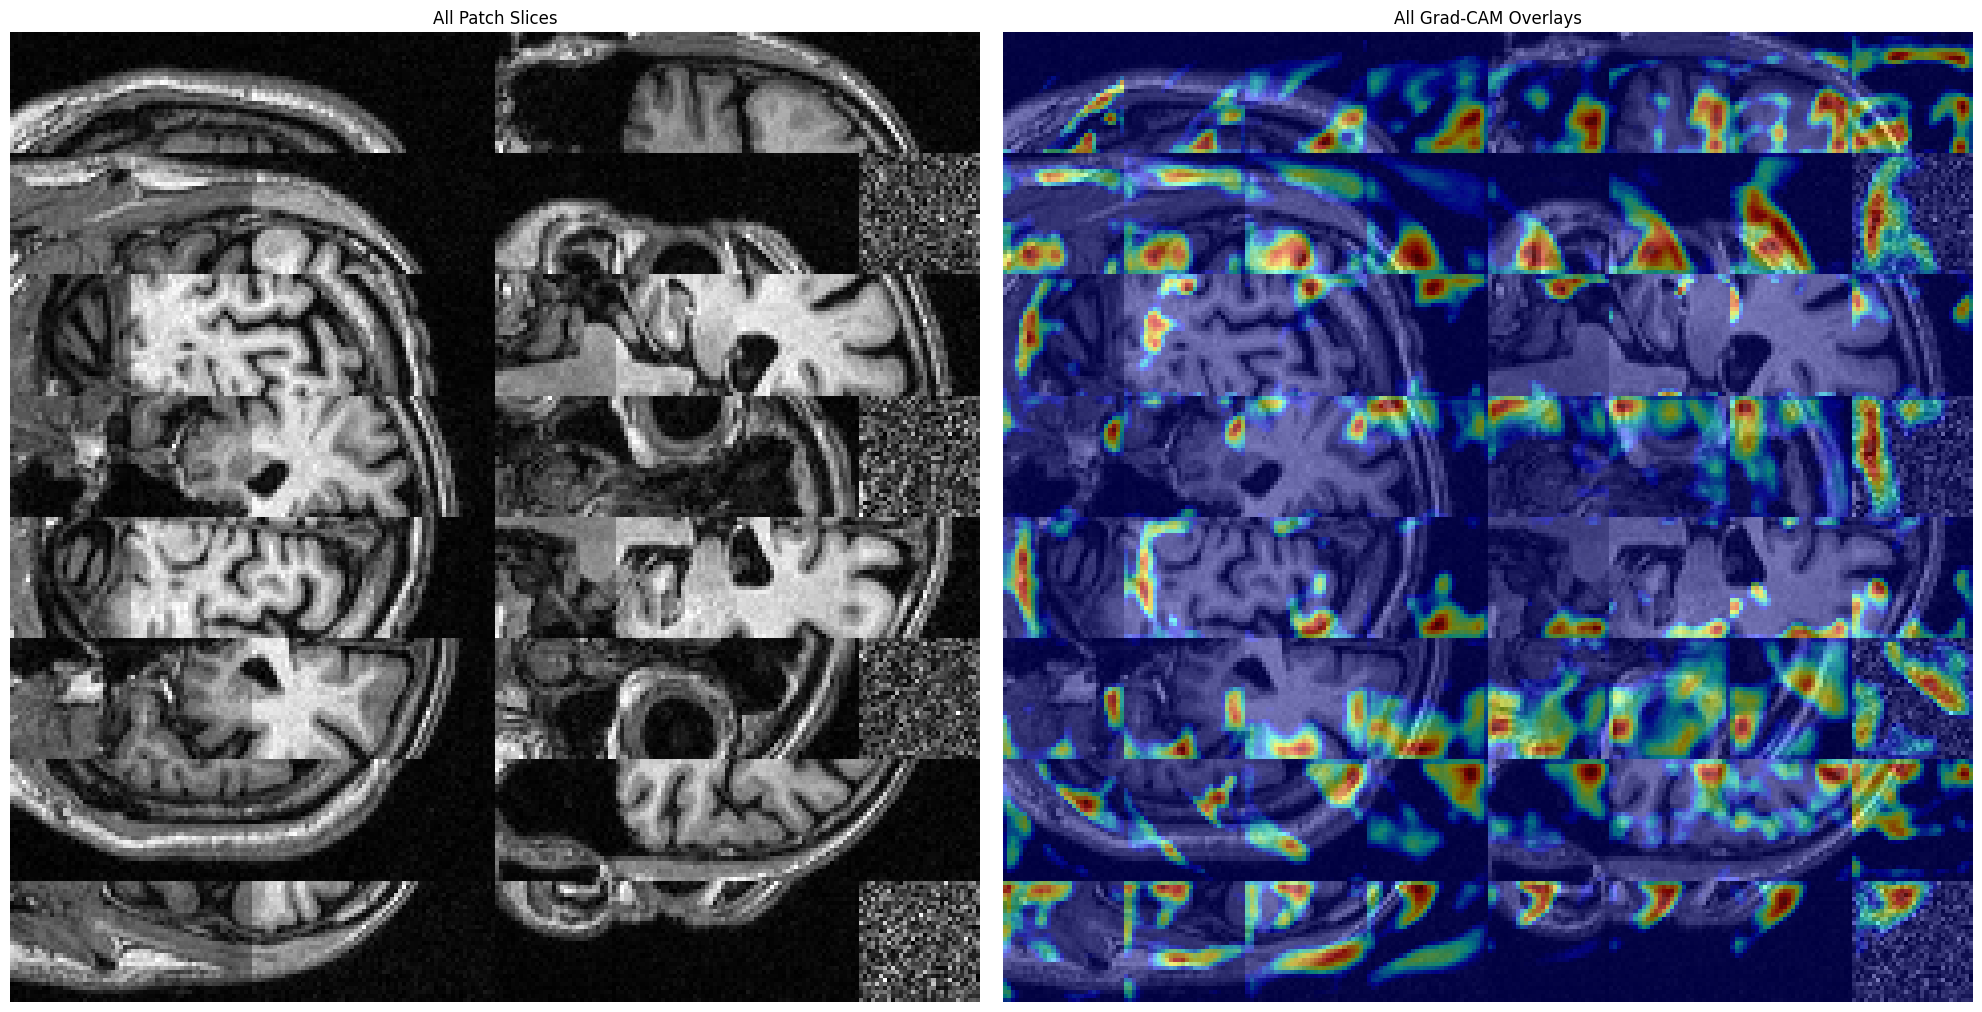

Final Evaluation Metrics: {'cnn_lr': {'accuracy': [0.5, 0.5, 0.5, 0.5714285714285714, 0.5714285714285714], 'auc': [np.float64(0.25), np.float64(0.6875), np.float64(0.1875), np.float64(0.25), np.float64(0.3333333333333333)], 'precision': [0.0, 0.0, 0.0, 0.0, 0.0], 'recall': [0.0, 0.0, 0.0, 0.0, 0.0]}, 'cnn_gnn': {'accuracy': [0.5, 0.5, 0.5, 0.42857142857142855, 0.42857142857142855], 'auc': [np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.6666666666666666)], 'precision': [0.5, 0.5, 0.5, 0.42857142857142855, 0.42857142857142855], 'recall': [1.0, 1.0, 1.0, 1.0, 1.0]}, 'cnn_pers_gnn': {'accuracy': [0.5, 0.5, 0.5, 0.42857142857142855, 0.42857142857142855], 'auc': [np.float64(0.5), np.float64(0.5), np.float64(0.375), np.float64(0.5), np.float64(0.5416666666666666)], 'precision': [0.5, 0.5, 0.5, 0.42857142857142855, 0.42857142857142855], 'recall': [1.0, 1.0, 1.0, 1.0, 1.0]}}


In [ ]:
results = train_evaluate_models(patches, persistence_images, labels) #hippocampus_segmented, persistence_images, labels, adni_csv_path, data_dir, atlas_path)
print("Final Evaluation Metrics:", results)

# **5. PyHealth Packaging**

**Create Custom ADNI Dataset Class**

In [ ]:
# Save this to adni_dataset.py

import os
import numpy as np
import pandas as pd
!pip install pyhealth
from pyhealth.datasets.base import Dataset
from pyhealth.utils.data_utils import download_and_extract

class ADNIDataset(Dataset):
    """
    Custom ADNI Dataset class for loading and processing ADNI data, including label extraction.
    """

    def __init__(self, data_dir: str, labels_file: str = "ADNIMERGE.csv", atlas_path: str = None):
        """
        Initializes the ADNI dataset.

        Args:
            data_dir: Directory containing the ADNI images.
            labels_file: The CSV file containing the ADNI subject labels (Default: "ADNIMERGE.csv").
            atlas_path: Path to the hippocampus atlas (Optional, needed for segmentation).
        """
        self.data_dir = data_dir
        self.labels_file = labels_file
        self.atlas_path = atlas_path
        self.labels = None
        self.patches = None
        self.hippocampus_segmented = None
        self.persistence_images = None
        self._load_data()

    def _load_data(self):
        """
        Loads the ADNI labels and image data.
        """
        # Load the ADNIMERGE file to get the labels
        adni_df = pd.read_csv(os.path.join(self.data_dir, self.labels_file))

        # Extract baseline diagnosis (DX_bl) and subject IDs (RID)
        labels_df = adni_df[['RID', 'DX_bl']]
        labels_df = labels_df[labels_df['DX_bl'].isin(['CN', 'AD'])]
        labels_df['label'] = labels_df['DX_bl'].map({'CN': 0, 'AD': 1})

        # Convert to numpy and store labels
        self.labels = labels_df[['RID', 'label']].to_numpy()

        # Here, you would load the MRI images and preprocess them as needed
        # Assuming we are working with preprocessed images in MNI space
        # Preprocessing images for TDA (Use preprocessing code here, e.g. preprocess_fmriprep_mni)
        for subject_id, label in self.labels:
            # Load image corresponding to subject_id, preprocess, and apply TDA
            image_path = os.path.join(self.data_dir, f"{subject_id}_mni.nii.gz")  # Example image path
            patches, hippocampus_segmented, persistence_images = preprocess_fmriprep_mni(image_path, self.atlas_path)

            # Append results (this could be a list or a more complex structure)
            self.patches = patches
            self.hippocampus_segmented = hippocampus_segmented
            self.persistence_images = persistence_images

    def get_data(self):
        """
        Returns the processed data for ADNI.
        """
        return self.patches, self.hippocampus_segmented, self.persistence_images, self.labels

    def __len__(self):
        """
        Returns the number of subjects in the dataset.
        """
        return len(self.labels)

**Define PyHealth Task**

In [ ]:
# Save this to adni_task.py

from pyhealth.tasks import Task
from adni_dataset import ADNIDataset

class ADNITask(Task):
    """
    PyHealth task for Alzheimer’s Disease Neuroimaging Initiative (ADNI) dataset.
    """

    def __init__(self, data_dir: str, atlas_path: str = None):
        """
        Initializes the ADNI task.

        Args:
            data_dir: Directory containing the ADNI images.
            atlas_path: Path to the hippocampus atlas (Optional).
        """
        self.data_dir = data_dir
        self.atlas_path = atlas_path
        self.dataset = None
        self._load_dataset()

    def _load_dataset(self):
        """
        Load the ADNI dataset.
        """
        self.dataset = ADNIDataset(data_dir=self.data_dir, atlas_path=self.atlas_path)

    def run(self):
        """
        Preprocesses and processes the ADNI dataset.
        """
        # Get data
        patches, hippocampus_segmented, persistence_images, labels = self.dataset.get_data()

        # Apply your model logic here (e.g., training, validation, testing)
        # Here, we're just returning the processed data.
        return patches, hippocampus_segmented, persistence_images, labels

**Use ADNI Task in PyHealth Pipeline**

In [ ]:
# Save this to run_project.py

from adni_task import ADNITask

# Define paths (adjust according to your data directory)
data_dir = "/path/to/adni/data"
atlas_path = "/path/to/hippocampus/atlas.nii.gz"  # Optional, if you want hippocampus segmentation

# Initialize and run the task
adni_task = ADNITask(data_dir=data_dir, atlas_path=atlas_path)
patches, hippocampus_segmented, persistence_images, labels = adni_task.run()

# use these outputs for your machine learning model.
print(f"Processed {len(labels)} subjects.")

'''
To integrate this custom task into PyHealth, make sure to add your adni_task.py and adni_dataset.py files
into the appropriate structure within your PyHealth-based project.

You can integrate this task with other PyHealth models and tasks seamlessly, as PyHealth supports multi-task
learning and data management workflows.
'''